In [0]:
pip install --upgrade numpy

Python interpreter will be restarted.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Not uninstalling numpy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-a16806e0-f59a-4477-b04d-812f99575ade
    Can't uninstall 'numpy'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 1.25.1 which is incompatible.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.25.1 which is incompatible.
Python interpreter will be restarted.


# Import Libs

In [0]:
# Libraries 
import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'#represent the begining of sentences
END_TOKEN = '<END>'# represent the end of sentences

np.random.seed(0)
random.seed(0)

/databricks/python/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package reuters to /root/nltk_data...


# Part1, Co-occurrence Matrix

# Pull Corpus

In [0]:
# data :: Reuters corpus, 10,788 news documents totaling 1.3 million words, span 90 categories and are split into train and test 

# now we pull only articles from "crude"(i.e. news articles about oil, gas, etc.)
# add <START> and <END> tokens to each of the document and lowercases words

# fileids() method pulls files
# in each file, get words using reuters.word(f)
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [0]:
# take a look at our corpus
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

# Make A Dict Storing Distinct Words

In [0]:
# now we need to know distinct words(word types or variable types) that occur in the corpus
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    corpus_words = sorted({word for sentence in corpus for word in sentence})
    num_corpus_words = len(corpus_words)

    return corpus_words, num_corpus_words

In [0]:
# do a sanity check for distinct_words() method
# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


# Function to Compute co-occurrence_matrix

In [0]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2ind = {}

    M = np.zeros([num_words,num_words])
    word2ind = {word:i for i,word in enumerate(words)}

    for body in corpus:
      for word_index, word in enumerate(body):
        for current_word_index in range(word_index-window_size, word_index+window_size+1):
          if current_word_index < 0 or current_word_index >= len(body) or current_word_index == word_index:
            continue
          index_context = word2ind[body[current_word_index]]
          index_center = word2ind[body[word_index]]
          M[index_center,index_context] +=1

    return M, word2ind

In [0]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


# Dimensionality Reduction Thru SVD

In [0]:
# use svd to take top k components and produce a new matrix of k dimensional embeddings
# only sklearn provides an efficient randomized algorithm for calculating large-scale truncated SVD
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=1)
    M_reduced = svd.fit_transform(M)

    print("Done.")
    return M_reduced

In [0]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


# Implement plot_embeddings

In [0]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """
    # get indexes from list of words
    index_words = [word2ind[word] for word in words]
    # get vecs
    word_vecs = [M_reduced[index_word] for index_word in index_words]
    
    xs = [word_vec[0] for word_vec in word_vecs]
    ys = [word_vec[1] for word_vec in word_vecs]

    for i, word in enumerate(words):
      x = xs[i]
      y = ys[i]
      plt.scatter(x,y,marker='x',color='red')
      plt.text(x,y,s=word,fontsize=9)
    plt.show()

--------------------------------------------------------------------------------
Outputted Plot:


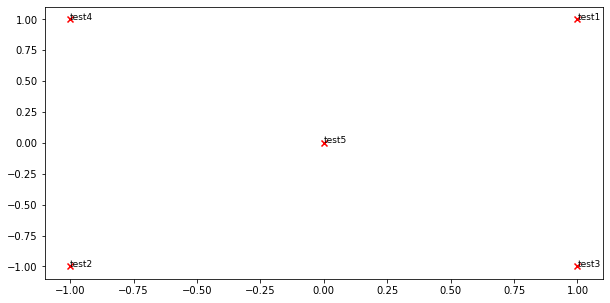

--------------------------------------------------------------------------------


In [0]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

# Putting All Together

Running Truncated SVD over 8185 words...
Done.


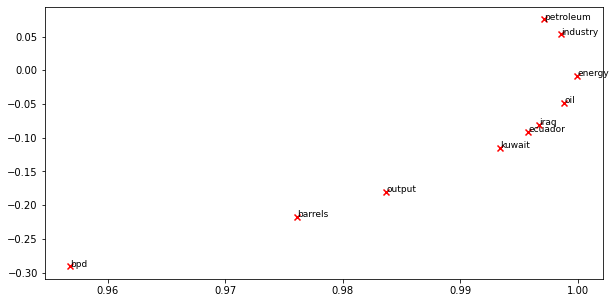

In [0]:
# compute co-occurrence matrix with fixed window of 4 over the corpus, then using TruncatedSVD to compute 2 dimensional embeddings of each word
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

# Part2, Prediction-based Word Vectors

In [0]:
# such as word2vec and GloVe
# now let's try GloVe 
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.key_to_index.keys()))
    return wv_from_bin

In [0]:
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


In [0]:
# now, put 10000 Glove vectors into a matrix M and run reduce_to_k_dim, reducing the vectors from 200d to 2d
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.key_to_index.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [0]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


<command-4086197954919428>:22: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  M.append(wv_from_bin.word_vec(w))
<command-4086197954919428>:31: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  M.append(wv_from_bin.word_vec(w))


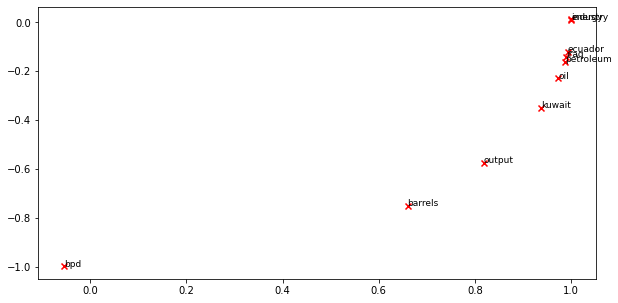

In [0]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_reduced_normalized, word2ind, words)

# Words with Multiple Meanings, Cosine Similarity

In [0]:
"""
to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective L1 and L2 Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors.
"""

In [0]:
wv_from_bin.most_similar('iraq')# this using cosine similarity to get top10 similar word with this word

Out[113]: [('iraqi', 0.8302668929100037),
 ('baghdad', 0.7587838172912598),
 ('iraqis', 0.7463918924331665),
 ('saddam', 0.7361562252044678),
 ('afghanistan', 0.7351369261741638),
 ('u.s.-led', 0.681342601776123),
 ('kuwait', 0.6784886121749878),
 ('hussein', 0.6759830117225647),
 ('us', 0.6694380044937134),
 ('iran', 0.645396888256073)]

# Word Distance, Cosine Distance

In [0]:
# cosine distance is 1 - cosine similarity

In [0]:
# we could use wv_from_bin.distance(w1,w2)

In [0]:

w1 = 'us'
w2 = 'sad'
w3 = 'cheerful'
a=wv_from_bin.distance(w1,w2)
b=wv_from_bin.distance(w1,w3)

b>a # so, b's distance between 'us' and 'cheerful' is bigger than 'sad' and 'cheerful'

Out[115]: True

# Analogies

In [0]:
# man:king :: woman:x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man'])) # the cosine similarity of k to m is almost same as x to w,
# k is 'woman', m is 'king', and x is 'man'

[('queen', 0.6978678107261658),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998258590698),
 ('elizabeth', 0.5463595986366272),
 ('daughter', 0.5399126410484314),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164473056793213)]


In [0]:
pprint.pprint(wv_from_bin.most_similar(positive=['woman','actor'], negative=['man']))
pprint.pprint(wv_from_bin.most_similar(positive=['paris', 'italy'], negative=['rome']))

[('actress', 0.857262372970581),
 ('actresses', 0.6734700798988342),
 ('actors', 0.6297088265419006),
 ('starring', 0.6084522008895874),
 ('starred', 0.5989463925361633),
 ('screenwriter', 0.595988929271698),
 ('dancer', 0.5881682634353638),
 ('comedian', 0.5791140794754028),
 ('singer', 0.5661861896514893),
 ('married', 0.5574131011962891)]
[('france', 0.7870438694953918),
 ('french', 0.6070881485939026),
 ('prohertrib', 0.6016789674758911),
 ('belgium', 0.5547007918357849),
 ('luxembourg', 0.5541552305221558),
 ('germany', 0.5328680276870728),
 ('europe', 0.5266215801239014),
 ('switzerland', 0.523548424243927),
 ('spain', 0.5062301754951477),
 ('european', 0.4787704646587372)]


# Incorrect Analogies based on embeddings

In [0]:
pprint.pprint(wv_from_bin.most_similar(positive=["foot", "glove"], negative=["hand"]))
pprint.pprint(wv_from_bin.most_similar(positive=["england", "india"], negative=["english"]))
pprint.pprint(wv_from_bin.most_similar(positive=["america", "peacock"], negative=["india"]))

[('45,000-square', 0.4922032654285431),
 ('15,000-square', 0.4649604558944702),
 ('10,000-square', 0.4544755816459656),
 ('6,000-square', 0.44975775480270386),
 ('3,500-square', 0.444133460521698),
 ('700-square', 0.44257497787475586),
 ('50,000-square', 0.4356396794319153),
 ('3,000-square', 0.43486514687538147),
 ('30,000-square', 0.4330596923828125),
 ('footed', 0.43236875534057617)]
[('pakistan', 0.663392961025238),
 ('lanka', 0.6324368715286255),
 ('australia', 0.6204169392585754),
 ('bangladesh', 0.5887335538864136),
 ('sri', 0.5656459331512451),
 ('zimbabwe', 0.5137112140655518),
 ('indies', 0.5070440769195557),
 ('delhi', 0.49937036633491516),
 ('africa', 0.49442628026008606),
 ('zealand', 0.4904975891113281)]
[('nbc', 0.3861715793609619),
 ('betsy', 0.38571250438690186),
 ('channing', 0.38541948795318604),
 ('abc', 0.3780362904071808),
 ('jamie', 0.373534619808197),
 ('carol', 0.36515089869499207),
 ('bonnie', 0.3609510660171509),
 ('turner', 0.3577595055103302),
 ('jennings',

# Bias Analyses in Word Vecs

In [0]:

# It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.


# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('employee', 0.6375863552093506),
 ('workers', 0.6068920493125916),
 ('nurse', 0.5837947130203247),
 ('pregnant', 0.5363885164260864),
 ('mother', 0.5321308970451355),
 ('employer', 0.5127025842666626),
 ('teacher', 0.5099576711654663),
 ('child', 0.5096741318702698),
 ('homemaker', 0.5019454956054688),
 ('nurses', 0.4970572590827942)]

[('workers', 0.611325740814209),
 ('employee', 0.5983108878135681),
 ('working', 0.5615329742431641),
 ('laborer', 0.5442320108413696),
 ('unemployed', 0.536851704120636),
 ('job', 0.5278826355934143),
 ('work', 0.5223963856697083),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.5054520964622498),
 ('factory', 0.4940454363822937)]


In [0]:
# Nurse, teacher, homemaker are among the top 10 terms most similar to "woman" and "worker" but most disimilar to "man".
# Laborer, mechanic and factory are examples of terms most similar to "man" and "worker" but most disimilar to "woman".

# Independent Analysis of Bias

In [0]:
# use the most_similar function to find another case where some bias is exhibited by the vectors
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'profession'], negative=['man']))
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'profession'], negative=['woman']))

"""
The professions that are most similar to "man" but most dissimilar to "woman" draws up a range of careers such as physicians, educator/teacher etc. and also features keywords such as practitioner and professionals.
On the flipside, the embeddings that are most similar to "woman" and profession but most dissimilar to "man" are reputation, skills, ethic, business, etc.
This example thus exhibits a clear bias in gender-specific career choices, since careers like physicians, educator/teacher have more similarity to "man" than "woman".
"""

[('professions', 0.5957457423210144),
 ('practitioner', 0.49884122610092163),
 ('teaching', 0.48292139172554016),
 ('nursing', 0.48211804032325745),
 ('vocation', 0.4788965880870819),
 ('teacher', 0.47160351276397705),
 ('practicing', 0.46937814354896545),
 ('educator', 0.46524327993392944),
 ('physicians', 0.4628995358943939),
 ('professionals', 0.4601394236087799)]
[('reputation', 0.5250176787376404),
 ('professions', 0.5178037881851196),
 ('skill', 0.49046966433525085),
 ('skills', 0.49005505442619324),
 ('ethic', 0.4897659420967102),
 ('business', 0.4875852167606354),
 ('respected', 0.485920250415802),
 ('practice', 0.482104629278183),
 ('regarded', 0.4778572618961334),
 ('life', 0.4760662019252777)]


In [0]:
# to test the source of bias, we can compute a vector g = ewoman - eman, where ewoman is the word vector of woman and eman is the word vector corresponding to the word man, this g could roughly encode the concept of gender, them by comparing the distance between g and a list of professions, or other types of words, we can uncover unhealthy gender stereotypes

# Further, using an equalization algorithm proposed by Boliukbasi et al. (2016), we can debias word vectors to some extent by modifying them to reduce gender stereotypes (but not eliminate it altogether).